# DETR Example
## 코드 분석 필요 
1. Input (학습 데이터 Input이 무엇인지)
2. Output (예측, 원하는 분류 class에 대한 결과 값 출력하는 방법)
### ※ 학습은 확인

In [27]:
!git clone https://github.com/facebookresearch/detr.git  ./tmp/packages/detr #cloning github repo of detr to import its unique loss

Cloning into './tmp/packages/detr'...
remote: Enumerating objects: 239, done.
Receiving objects:  77% (185/239), 196.01 KiB | 344.00 KiB/sReceiving objects:  77% (185/239), 1.68 MiB | 1.51 MiB/sReceiving objects:  78% (187/239), 8.64 MiB | 5.16 MiB/sremote: Total 239 (delta 0), reused 0 (delta 0), pack-reused 239
Receiving objects: 100% (239/239), 12.84 MiB | 5.16 MiB/s, done.
Resolving deltas: 100% (125/125), done.
Checking connectivity... done.


In [29]:
!ls ./tmp/packages/detr/*

./tmp/packages/detr/Dockerfile	./tmp/packages/detr/README.md
./tmp/packages/detr/engine.py	./tmp/packages/detr/requirements.txt
./tmp/packages/detr/hubconf.py	./tmp/packages/detr/run_with_submitit.py
./tmp/packages/detr/LICENSE	./tmp/packages/detr/test_all.py
./tmp/packages/detr/main.py	./tmp/packages/detr/tox.ini

./tmp/packages/detr/d2:
configs  converter.py  detr  README.md	train_net.py

./tmp/packages/detr/datasets:
coco_eval.py	  coco.py      panoptic_eval.py
coco_panoptic.py  __init__.py  transforms.py

./tmp/packages/detr/models:
backbone.py  __init__.py  position_encoding.py	transformer.py
detr.py      matcher.py   segmentation.py

./tmp/packages/detr/util:
box_ops.py  __init__.py  misc.py  plot_utils.py


In [31]:
!pip install torch

     |████████████████████████████████| 748.8 MB 10 kB/s 


In [34]:
!pip install torchvision

     |████████████████████████████████| 5.9 MB 1.1 MB/s 


In [36]:
!pip install albumentations

     |████████████████████████████████| 117 kB 1.1 MB/s 
     |████████████████████████████████| 948 kB 3.4 MB/s 
     |████████████████████████████████| 1.0 MB 5.8 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65162 sha256=2945453ab0710d4ccaac63160b9928b8053f2e148941571df0876686ab7637f6
  Stored in directory: /home/lab10/.cache/pip/wheels/38/db/df/d6cb0be184075a7799c1fd79240c389c16f51dfe18dc3332fa
Successfully built albumentations


In [1]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.auto import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.extend(['./tmp/packages/detr/'])

from models.matcher import HungarianMatcher
from models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

In [2]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        
    @property
    def avg(self):
        return (self.sum / self.count) if self.count>0 else 0

In [3]:
n_folds = 5
seed = 42
null_class_coef = 0.5
num_classes = 1
num_queries = 100
BATCH_SIZE = 8
LR = 5e-5
lr_dict = {'backbone':0.1,'transformer':1,'embed':1,'final': 5}
EPOCHS = 2
max_norm = 0
model_name = 'detr_resnet50'

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [5]:
seed_everything(seed)

In [6]:
import pandas as pd

In [7]:
marking = pd.read_csv('/home/lab10/JJC/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))

for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i] 
    
marking.drop(columns=['bbox'], inplace=True)

In [8]:
marking.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [9]:
import numpy as np 

In [17]:
# 이미지 파일명과 source(?), 박스 정보를 가져옴

image_data = marking.groupby('image_id')
images = list(map(lambda x: x.split('.')[0], os.listdir('/home/lab10/JJC/train/')))

def get_data(img_id):
    if img_id not in image_data.groups:
        return dict(image_id=img_id, source='', boxes=list())
    
    data  = image_data.get_group(img_id)
    source = np.unique(data.source.values)
    assert len(source)==1, 'corrupted data: %s image_id has many sources: %s' %(img_id,source)
    source=source[0]
    boxes = data[['x','y','w','h']].values
    return dict(image_id = img_id, source=source, boxes = boxes)

image_list = [get_data(img_id) for img_id in images]

In [18]:
# image_list[0]

In [19]:
print(f'total number of images: {len(image_list)}, images with bboxes: {len(image_data)}')
null_images=[x['image_id'] for x in image_list if len(x['boxes'])==0]
len(null_images)

total number of images: 3422, images with bboxes: 3373


49

In [14]:
def add_fold_index(lst,n_folds):
    lens = [len(x['boxes']) for x in lst]
    lens_unique = np.unique(lens)
    i = np.random.randint(n_folds)
    fold_indexes = [[] for _ in range(n_folds)]
    idx = []
    
    for _l in lens_unique:
        idx.extend(np.nonzero(lens==_l)[0].tolist())
        if len(idx)<n_folds: continue
        random.shuffle(idx)
        while len(idx)>= n_folds:
            fold_indexes[i].append(lst[idx.pop()]['image_id'])
            i = (i+1) % n_folds
    while len(idx):
        fold_indexes[i].append(lst[idx.pop()]['image_id'])
        i = (i+1) % n_folds
    
    return fold_indexes
    
sources = np.unique([x['source'] for x in image_list])
splitted_image_list = {s:sorted([x for x in image_list if x['source']==s],key=lambda x: len(x['boxes'])) 
                       for s in sources}
splitted_image_list = {k: add_fold_index(v,n_folds=n_folds) for k,v in splitted_image_list.items()}

fold_indexes = [[] for _ in range(n_folds)]
for k,v in splitted_image_list.items():
    for i in range(n_folds):
        fold_indexes[i].extend(v[i])  
    
print([len(v) for v in fold_indexes])

[685, 684, 684, 684, 685]


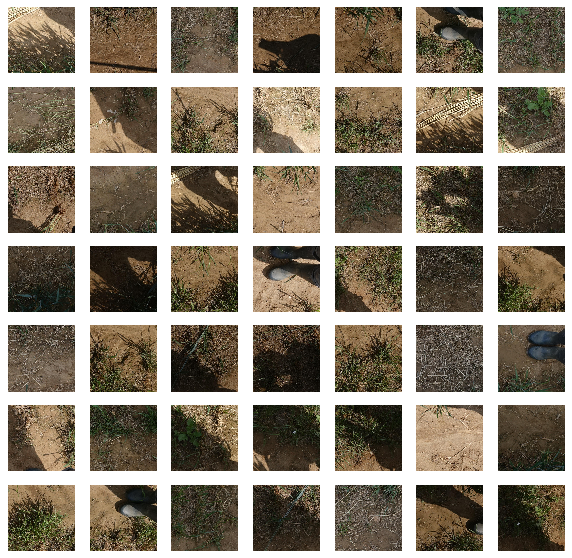

In [21]:
# True로 할 시 박스 정보 없는 데이터 보여줌
if False:
    plt.figure(figsize=(10,10))
    for i,img in enumerate(null_images):
        plt.subplot(7,7,i+1)
        plt.imshow(plt.imread(f'/home/lab10/JJC/train/{img}.jpg'))
        plt.axis('off')
        plt.axis('tight')
        plt.axis('equal')

    plt.show()

In [25]:
def get_train_transforms():
    return A.Compose(
        [
            A.OneOf(
            [
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),      
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)
            ],
            p=0.9),         
            #A.ToGray(p=0.01),         
            A.HorizontalFlip(p=0.5),         
            A.VerticalFlip(p=0.5),         
            A.Resize(height=512, width=512, p=1),      
            A.Normalize(max_pixel_value=1),
            #A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
            ToTensorV2(p=1.0)
        ], 
        p=1.0,         
        bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
        )

def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=1.0),
                      A.Normalize(max_pixel_value=1),
                      ToTensorV2(p=1.0),
                      ], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

In [26]:
# DataSet 생성
DIR_TRAIN = '/home/lab10/JJC/train/'
class WheatDataset(Dataset):
    def __init__(self,image_list,transforms=None):
        self.images = image_list
        self.transforms = transforms
        self.img_ids = {x['image_id']:i for i,x in enumerate(image_list)}
        
    def get_indices(self,img_ids):
        return [self.img_ids[x] for x in img_ids]
        
    def __len__(self) -> int:
        return len(self.images)
    
    def __getitem__(self,index):
        record = self.images[index]
        image_id = record['image_id']

        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # DETR takes in data in coco format 
        boxes = record['boxes'] 
        
        labels =  np.zeros(len(boxes), dtype=np.int32)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image  = sample['image']
            boxes  = sample['bboxes']
            labels = sample['labels']

        _,h,w = image.shape
        boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        ## detr uses center_x,center_y,width,height !!
        if len(boxes)>0:
            boxes = np.array(boxes)
            boxes[:,2:] /= 2
            boxes[:,:2] += boxes[:,2:]
        else:
            boxes = np.zeros((0,4))
    
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        
        return image, target, image_id

In [27]:
train_ds = WheatDataset(image_list,get_train_transforms())
valid_ds = WheatDataset(image_list,get_valid_transforms())

In [28]:
train_ds

In [29]:
def show_example(image,target,image_id=None):
    np_image = image.cpu().numpy().transpose((1,2,0))
    # unnormalize the image
    np_image = np_image*np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406])
    #np_image = (np_image*255).astype(np.uint8)
    target = {k: v.cpu().numpy() for k, v in target.items()} 
    
    boxes = target['boxes']
    h,w,_ = np_image.shape
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
        
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(np_image,
                  (box[0]-box[2], box[1]-box[3]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 1)
        
    ax.set_axis_off()
    ax.imshow(np_image)
    ax.set_title(image_id)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


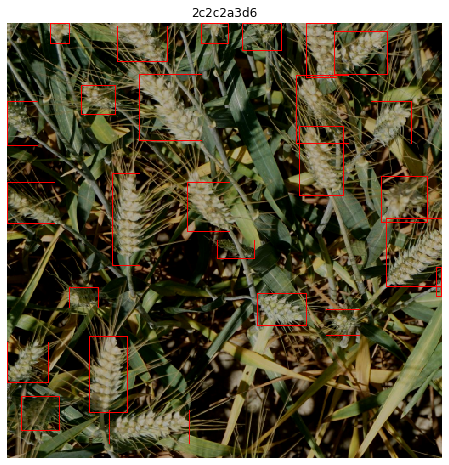

In [30]:
show_example(*train_ds[350])

In [31]:
def DETRModel(num_classes,model_name=model_name):
    model = torch.hub.load('facebookresearch/detr', model_name, pretrained=False, num_classes=num_classes)
    def parameter_groups(self):
        return { 'backbone': [p for n,p in self.named_parameters()
                              if ('backbone' in n) and p.requires_grad],
                 'transformer': [p for n,p in self.named_parameters() 
                                 if (('transformer' in n) or ('input_proj' in n)) and p.requires_grad],
                 'embed': [p for n,p in self.named_parameters()
                                 if (('class_embed' in n) or ('bbox_embed' in n) or ('query_embed' in n)) 
                           and p.requires_grad]}
    setattr(type(model),'parameter_groups',parameter_groups)
    return model

class DETRModel(nn.Module):
    def __init__(self,num_classes=1):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        
        self.model = torch.hub.load('facebookresearch/detr', model_name, pretrained=True)
        
        self.out = nn.Linear(in_features=self.model.class_embed.out_features,out_features=num_classes+1)
        
    def forward(self,images):
        d = self.model(images)
        d['pred_logits'] = self.out(d['pred_logits'])
        return d
    
    def parameter_groups(self):
        return { 
            'backbone': [p for n,p in self.model.named_parameters()
                              if ('backbone' in n) and p.requires_grad],
            'transformer': [p for n,p in self.model.named_parameters() 
                                 if (('transformer' in n) or ('input_proj' in n)) and p.requires_grad],
            'embed': [p for n,p in self.model.named_parameters()
                                 if (('class_embed' in n) or ('bbox_embed' in n) or ('query_embed' in n)) 
                           and p.requires_grad],
            'final': self.out.parameters()
            }

In [32]:
model = DETRModel()
model.parameter_groups().keys()
#type(model)

Using cache found in /home/lab10/.cache/torch/hub/facebookresearch_detr_master


dict_keys(['backbone', 'transformer', 'embed', 'final'])

In [33]:
'''
code taken from github repo detr , 'code present in engine.py'
'''

matcher = HungarianMatcher(cost_giou=2,cost_class=1,cost_bbox=5)

weight_dict = {'loss_ce': 1, 'loss_bbox': 5 , 'loss_giou': 2}

losses = ['labels', 'boxes', 'cardinality']

In [34]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [35]:
# 데이터를 Torch DataLoader 형식으로 변환

def get_fold(fold):
    
    train_indexes = train_ds.get_indices([x for i,f in enumerate(fold_indexes) if i!=fold for x in f])
    valid_indexes = valid_ds.get_indices(fold_indexes[fold])
    
    train_data_loader = DataLoader(
        torch.utils.data.Subset(train_ds,train_indexes),
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
        torch.utils.data.Subset(valid_ds,valid_indexes),
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        collate_fn=collate_fn
    )
    return train_data_loader,valid_data_loader

In [36]:
train_loader,valid_loader = get_fold(0)

In [37]:
valid_iter = iter(valid_loader)
batch  = next(valid_iter)
#batch  = next(valid_iter)

In [38]:
images,targets,image_id = batch
torch.cat([v['boxes'] for v in targets])

tensor([], size=(0, 4))

In [46]:
import util.box_ops  as box_ops

def challenge_metric(outputs,targets):
    logits = outputs['pred_logits']
    boxes  = outputs['pred_boxes']
    return sum(avg_precision(logit[:,0]-logit[:,1],box,target['boxes'])
            for logit,box,target in zip(logits,boxes,targets))/len(logits)

    return {target['image_id']:avg_precision(logit[:,0]-logit[:,1],box,target['boxes'])
            for logit,box,target in zip(logits,boxes,targets)}


@torch.no_grad()
def avg_precision(logit,pboxes,tboxes,reduce=True):
    idx = logit.gt(0)
    if sum(idx)==0 and len(tboxes)==0: 
        return 1 if reduce else [1]*6
    if sum(idx)>0 and len(tboxes)==0: 
        return 0 if reduce else [0]*6
    
    pboxes = pboxes[idx]
    logit = logit[idx]
    
    idx = logit.argsort(descending=True)
    pboxes=box_ops.box_cxcywh_to_xyxy(pboxes.detach()[idx])
    tboxes=box_ops.box_cxcywh_to_xyxy(tboxes)
    
    iou = box_ops.box_iou(pboxes,tboxes)[0].cpu().numpy()
    prec = [precision(iou,th) for th in [0.5,0.55,0.6,0.65,0.7,0.75]]
    if reduce:
        return sum(prec)/6
    return prec
    

def precision(iou,th):
    #if iou.shape==(0,0): return 1

    #if min(*iou.shape)==0: return 0
    tp = 0
    iou = iou.copy()
    num_pred,num_gt = iou.shape
    for i in range(num_pred):
        _iou = iou[i]
        n_hits = (_iou>th).sum()
        if n_hits>0:
            tp += 1
            j = np.argmax(_iou)
            iou[:,j] = 0
    return tp/(num_pred+num_gt-tp)

In [47]:
def gen_box(n,scale=1):
    par = torch.randn((n,4)).mul(scale).sigmoid() 
    max_hw = 2*torch.min(par[:,:2],1-par[:,:2])
    par[:,2:] = par[:,2:].min(max_hw)
    return par

pboxes = gen_box(50)
logit = torch.randn(50)
tboxes = gen_box(3) 
#iou = 
avg_precision(logit,pboxes,tboxes)
#iou.gt(0.5),iou,pboxes,tboxes

0.015151515151515152

In [48]:
# 학습 함수
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()
    
    tk0 = tqdm(data_loader, total=len(data_loader),leave=False)
    log = None
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        batch_size = len(images)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        

        output = model(images)
        
        loss_dict = criterion(output, targets)
        
        if log is None:
            log = {k:AverageMeter() for k in loss_dict}
            log['total_loss'] = AverageMeter()
            log['avg_prec'] = AverageMeter()
            
        weight_dict = criterion.weight_dict
        
        total_loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        total_loss.backward()
        
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
        log['total_loss'].update(total_loss.item(),batch_size)
        
        for k,v in loss_dict.items():
            log[k].update(v.item(),batch_size)
            
        log['avg_prec'].update(challenge_metric(output,targets),batch_size)
            
        tk0.set_postfix({k:v.avg for k,v in log.items()}) 
        
    return log

In [49]:
# 평가 함수
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    log = None
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader),leave=False)
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            batch_size = len(images)
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            if log is None:
                log = {k:AverageMeter() for k in loss_dict}
                log['total_loss'] = AverageMeter()
                log['avg_prec'] = AverageMeter()
            
            for k,v in loss_dict.items():
                log[k].update(v.item(),batch_size)
        
            total_loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            log['total_loss'].update(total_loss.item(),batch_size)
            log['avg_prec'].update(challenge_metric(output,targets),batch_size)
            
            tk0.set_postfix({k:v.avg for k,v in log.items()}) 
    
    return log #['total_loss']

In [52]:
# 실행 로그 처리, Run 함수

import json

class Logger:
    def __init__(self,filename,format='csv'):
        self.filename = filename + '.' + format
        self._log = []
        self.format = format
    def save(self,log,epoch=None):
        log['epoch'] = epoch+1
        self._log.append(log)
        if self.format == 'json':
            with open(self.filename,'w') as f:
                json.dump(self._log,f)
        else:
            pd.DataFrame(self._log).to_csv(self.filename,index=False)
            
            
def run(fold,epochs=EPOCHS):
    
    train_data_loader,valid_data_loader = get_fold(fold)
    
    logger = Logger(f'log_{fold}')
    device = torch.device('cuda')
    model = DETRModel(num_classes=num_classes)
    model = model.to(device)
    criterion = SetCriterion(num_classes, 
                             matcher, weight_dict, 
                             eos_coef = null_class_coef, 
                             losses=losses)
    
    criterion = criterion.to(device)
    

    optimizer = torch.optim.AdamW([{
        'params': v,
        'lr': lr_dict.get(k,1)*LR
    } for k,v in model.parameter_groups().items()], weight_decay=1e-4)
    
    best_precision = 0
    header_printed = False
    for epoch in range(epochs):
        train_log = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_log = eval_fn(valid_data_loader, model,criterion, device)
    
        log = {k:v.avg for k,v in train_log.items()}
        log.update({'V/'+k:v.avg for k,v in valid_log.items()})
        logger.save(log,epoch)
        keys = sorted(log.keys())
        
        if not header_printed:
            print(' '.join(map(lambda k: f'{k[:8]:8}',keys)))
            header_printed = True
        print(' '.join(map(lambda k: f'{log[k]:8.3f}'[:8],keys)))
        
        if log['V/avg_prec'] > best_precision:
            best_precision = log['V/avg_prec']
            print('Best model found at epoch {}'.format(epoch+1))
            torch.save(model.state_dict(), f'detr_best_{fold}.pth')
        

In [53]:
import gc
gc.collect()

7

In [2]:
# 학습 실행
run(fold=0,epochs=1)

In [56]:
# 아직 실행이 안되는 부분, 예측 결과 보여주는 곳

In [57]:
def show_predictions(images,outputs,targets):
    _,h,w = images[0].shape
    
    boxes = targets[0]['boxes'].cpu().numpy() #.astype(np.int32)
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
    np_image = images[0].permute(1,2,0).cpu().numpy()
    np_image = np_image*np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406])
    
    #outputs = [{k: v.cpu() for k, v in output.items()}]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(np_image,
                  (box[0]-box[2], box[1]-box[3]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 2)
    
    oboxes = outputs['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    prob   = outputs['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]
    for box,p in zip(oboxes,prob):
        if p>0.5:
            color = (0,0,220) if p>0.5 else (0,220,0)
            cv2.rectangle(np_image,
                      (box[0]-box[2], box[1]-box[3]),
                      (box[2]+box[0], box[3]+box[1]),
                      color, 1)
    
    ax.set_axis_off()
    ax.imshow(np_image)
    #return images,outputs,targets

In [58]:
model = DETRModel(num_classes=num_classes)#,num_queries=num_queries
model.load_state_dict(torch.load("./detr_best_0.pth"))
model.to(torch.device('cuda'))
None

Using cache found in /home/lab10/.cache/torch/hub/facebookresearch_detr_master


In [59]:
train_loader,valid_loader = get_fold(0)
valid_iter = iter(valid_loader)

In [104]:
#temp

# 참고자료
https://www.kaggle.com/prokaj/end-to-end-object-detection-with-transformers-detr